In [1]:
version = 'v20250521'

### Read in Germany data for test

In [2]:
import pandas as pd
df = pd.read_parquet('./material/soc.snr_overlaid_v20250301.pq')
df = df.loc[df['ref'].isin(['thuenen.bze.lw'])]
print(df.shape)

(16334, 468)


### Get profile with multiple depths

In [7]:
multi_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) > 2)
multi_depth_interpolate = multi_depth_groups.groupby(['lat', 'lon', 'time']).filter(lambda g: not (g['hzn_dep'] == 10).any())
print("multi-depth group needs interpolation count:", multi_depth_interpolate.shape)

multi-depth group needs interpolation count: (16309, 468)


### Create pseudo gaps, and predict them using SOC measurements from other depths

A profile-internal pseudo-gap validation was conducted on German multi-depth SOC profiles by removing the second depth (not top layer, and not bottom to avoid extrapolation; usually the secod depth interval after top soil is closest to 10cm) and re-estimating SOC at that depth using the Piecewise Cubic Hermite Interpolating Polynomial (PCHIP) method.

In [13]:
import numpy as np
from scipy.interpolate import PchipInterpolator

itpl_records = []

for (lat, lon, time), g in multi_depth_interpolate.groupby(['lat', 'lon', 'time']):
    # Clean & sort
    g = (g
         .loc[np.isfinite(g['hzn_dep']) & np.isfinite(g['soc'])]
         .drop_duplicates(subset=['hzn_dep'])
         .sort_values('hzn_dep'))

    # hold out the second depth easurement, which is usually closest to 10 cm ---
    hold_idx = g.index[1]                           # second row after sorting
    target_depth = float(g.loc[hold_idx, 'hzn_dep'])
    obs_soc = float(g.loc[hold_idx, 'soc'])
    
    # create pseudo gap, reduced profile (remove the held-out row)
    g_red = g.drop(index=hold_idx)

    depths = g_red['hzn_dep'].to_numpy(dtype=float)
    socs   = g_red['soc'].to_numpy(dtype=float)
    
    
    try:
        pc = PchipInterpolator(depths, socs, extrapolate=False)
        pred_soc = float(pc(target_depth))
    except Exception:
        pred_soc = np.nan
        
        
    new_record = g.loc[hold_idx].copy()
    new_record['pred'] = pred_soc
    itpl_records.append(new_record)

    
interpolated_records = pd.DataFrame(itpl_records)

### Report accuracy

=== PCHIP pseudo-gap interpolation report ===
N SOC (g/kg) profiles (after filtering): 2940
MAE     : 8.259
RMSE    : 24.592
Bias    : -1.894
R2     : 0.800


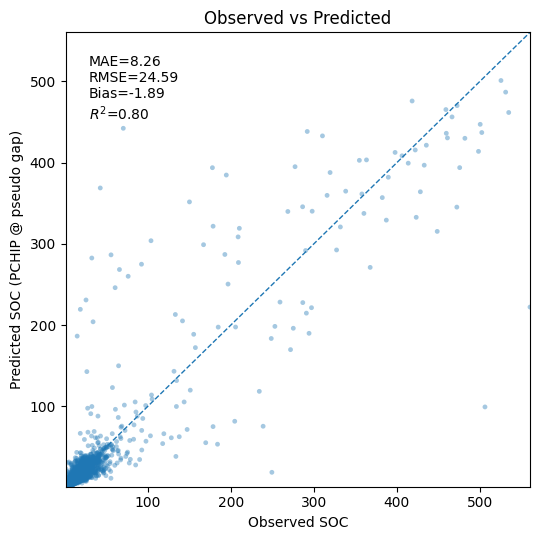

In [24]:
import matplotlib.pyplot as plt

# calc metrics
interpolated_records['error'] = interpolated_records['pred'] - interpolated_records['soc']
interpolated_records['abs_err'] = interpolated_records['error'].abs()

mae  = interpolated_records['abs_err'].mean()
rmse = np.sqrt((interpolated_records['error']**2).mean())
bias = interpolated_records['error'].mean()
y_true = interpolated_records['soc'].to_numpy(dtype=float)
y_pred = interpolated_records['pred'].to_numpy(dtype=float)
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - y_true.mean())**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

print("=== PCHIP pseudo-gap interpolation report ===")
print(f"N SOC (g/kg) profiles (after filtering): {len(interpolated_records)}")
print(f"MAE     : {mae:.3f}")
print(f"RMSE    : {rmse:.3f}")
print(f"Bias    : {bias:.3f}")
print(f"R2     : {r2:.3f}")

plt.figure(figsize=(5.5,5.5))
plt.scatter(y_true, y_pred, s=12, alpha=0.4, edgecolor='none')
# 1:1 line
mn = np.nanmin([y_true.min(), y_pred.min()])
mx = np.nanmax([y_true.max(), y_pred.max()])
plt.plot([mn, mx], [mn, mx], linestyle='--', linewidth=1)
plt.xlim(mn, mx); plt.ylim(mn, mx)
plt.xlabel("Observed SOC")
plt.ylabel("Predicted SOC (PCHIP @ pseudo gap)")
plt.title("Observed vs Predicted")
# annotate metrics
plt.text(0.05, 0.95,
         f"MAE={mae:.2f}\nRMSE={rmse:.2f}\nBias={bias:.2f}\n$R^2$={r2:.2f}",
         transform=plt.gca().transAxes,
         ha='left', va='top')
plt.tight_layout()
plt.show()



The interpolated results showed strong agreement with the observed values, achieving an R2 of 0.80, demonstrating the robustness of PCHIP for depth harmonization. The mean absolute error (MAE) and root-mean-square error (RMSE) were 8.26 and 25.59 g/kg, respectively. A slight negative bias (−1.89 g kg⁻¹) indicates a minor underestimation tendency. O

Overall, these results confirm that PCHIP provides a reliable, shape-preserving interpolation for harmonizing SOC measurements to a standardized depth. One limitation is that, because the test relied on profiles with multiple measured depths but no observation exactly at 10 cm, only pseudo-gap experiments could be performed. Consequently, the true external accuracy of the 10 cm depth standardization cannot be directly assessed.